In [2]:
from google.colab import drive
drive.mount('/content/drive')


# Cambiar el directorio de trabajo
%cd '/content/drive/My Drive/tfg/tfg/'

# Mostrar el directorio actual para confirmar el cambio
directorio_actual = %pwd
print("Directorio actual:", directorio_actual)

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/10WLcTPxhJDTxR9pv6DkdJbsqxpkkFOIV/tfg/tfg
Directorio actual: /content/drive/.shortcut-targets-by-id/10WLcTPxhJDTxR9pv6DkdJbsqxpkkFOIV/tfg/tfg


In [13]:
import os
import pandas as pd
path_actual = os.getcwd()
subdirectorio = 'datas'
file_train = 'df_train.csv'
path_train = os.path.join(path_actual, subdirectorio, file_train)

In [14]:
file_valid = 'df_valid.csv'
path_valid = os.path.join(path_actual, subdirectorio, file_valid)

In [15]:
import pandas as pd

df_train = pd.read_csv(path_train, index_col=None)
df_valid = pd.read_csv(path_valid, index_col=None)

In [16]:
from sklearn.preprocessing import MinMaxScaler
# Reordena las columnas según la nueva estructura
df_train = df_train[['PDGcode', 'eventID', 'hitX', 'hitY', 'hitZ', 'hitInteg']]
df_valid = df_valid[['PDGcode', 'eventID', 'hitX', 'hitY', 'hitZ', 'hitInteg']]

# Convertir PDGcode a clasificación binaria
df_train['PDGcode'] = df_train['PDGcode'].apply(lambda x: 0 if x == 211 else (1 if x == 321 else None))
df_valid['PDGcode'] = df_valid['PDGcode'].apply(lambda x: 0 if x == 211 else (1 if x == 321 else None))

# Eliminar filas con valores nulos
df_train = df_train.dropna()
df_valid = df_valid.dropna()

# Obtén las características (X) y las etiquetas (y) de tus datos
X_train = df_train[['eventID', 'hitX', 'hitY', 'hitZ', 'hitInteg']].values
y_train = df_train['PDGcode'].values

X_valid = df_valid[['eventID', 'hitX', 'hitY', 'hitZ', 'hitInteg']].values
y_valid = df_valid['PDGcode'].values


EPOCAS = 50

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

In [6]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


def create_model_CNN(input_dim):
    model = Sequential()
    # Capa convolucional 1
    model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(1, input_dim)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Capa convolucional 2
    model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Capa convolucional 3 - nueva capa añadida
    model.add(Conv1D(filters=256, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=1))  # Agregando pooling aquí para reducir dimensiones gradualmente
    model.add(Dropout(0.4))

    model.add(Conv1D(filters=512, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=1))  # Agregando pooling aquí para reducir dimensiones gradualmente
    model.add(Dropout(0.4))

    model.add(Conv1D(filters=1024, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=1))  # Agregando pooling aquí para reducir dimensiones gradualmente
    model.add(Dropout(0.4))

    # Aplanamiento y capas densas
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))  # Aumento en la capacidad de la capa densa
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Capa de salida para clasificación binaria

    return model


EPOCAS = 10

# Ajusta las dimensiones de las características de entrada
num_features = X_train.shape[1]
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, num_features))
X_valid_reshaped = X_valid.reshape((X_valid.shape[0], 1, num_features))

# Define un callback para reducir el LR basado en la pérdida de validació

# Crea y compila el modelo LSTM
model_CNN = create_model_CNN(num_features)

model_CNN.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Entrena el modelo
# Define los callbacks
# checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
# Entrena el modelo con los callbacks
history_CNN = model_CNN.fit(X_train_reshaped, y_train, epochs=EPOCAS, batch_size=1048, validation_data=(X_valid_reshaped, y_valid), callbacks = [early_stop])

# Evalúa el modelo en el conjunto de prueba
loss, accuracy = model_CNN.evaluate(X_valid_reshaped, y_valid)
print("Loss:", loss)
print("Accuracy:", accuracy)



Epoch 1/10
11081/11081 [==============================] - 283s 24ms/step - loss: 0.4866 - accuracy: 0.7657 - val_loss: 0.4995 - val_accuracy: 0.7399
Epoch 2/10
11081/11081 [==============================] - 268s 24ms/step - loss: 0.4725 - accuracy: 0.7738 - val_loss: 0.4850 - val_accuracy: 0.7538
Epoch 3/10
11081/11081 [==============================] - 268s 24ms/step - loss: 0.4688 - accuracy: 0.7761 - val_loss: 0.5280 - val_accuracy: 0.7153
Epoch 4/10
11081/11081 [==============================] - 280s 25ms/step - loss: 0.4668 - accuracy: 0.7774 - val_loss: 0.5073 - val_accuracy: 0.7408
Epoch 5/10
11081/11081 [==============================] - 278s 25ms/step - loss: 0.4655 - accuracy: 0.7780 - val_loss: 0.4650 - val_accuracy: 0.7764
Epoch 6/10
11081/11081 [==============================] - 275s 25ms/step - loss: 0.4647 - accuracy: 0.7787 - val_loss: 0.4829 - val_accuracy: 0.7558
Epoch 7/10
11081/11081 [==============================] - 283s 26ms/step - loss: 0.4641 - accuracy: 0.7791

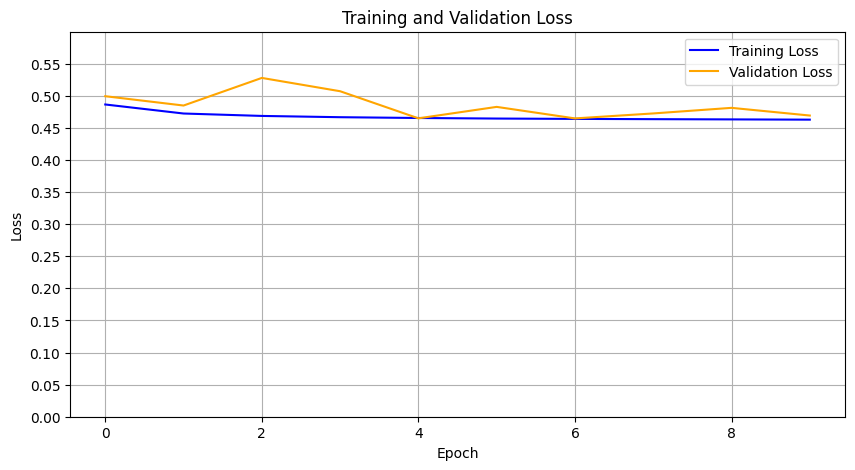

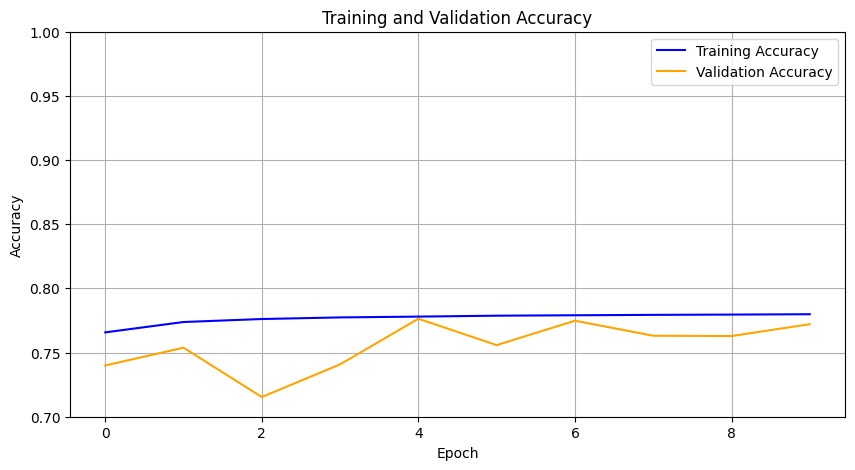

In [9]:
import matplotlib.pyplot as plt
import numpy as np
# Obtén el historial de entrenamiento
history =history_CNN.history

# Grafica la pérdida
plt.figure(figsize=(10, 5))
plt.plot(history['loss'], label='Training Loss', color='blue')
plt.plot(history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
min_y=0
max_y=0.6
plt.ylim(min_y, max_y)
plt.yticks(np.arange(min_y, max_y, 0.05))
plt.show()

# Grafica el accuracy
plt.figure(figsize=(10, 5))
plt.plot(history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
min_y=0.7
max_y=1
plt.ylim(min_y, max_y)
plt.yticks(np.arange(min_y, max_y, 0.05))
plt.show()

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Bidirectional, GRU, GlobalAveragePooling1D, Dense

# Define una función para crear el modelo GRU con una sola capa
def create_model_GRU(input_dim):
    model = Sequential()
    model.add(Bidirectional(GRU(100, return_sequences=True), input_shape=(None, input_dim)))
    model.add(GlobalAveragePooling1D())  # Cambio aquí
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Ajusta las dimensiones de las características de entrada
num_features = X_train.shape[1]
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, num_features))
X_valid_reshaped = X_valid.reshape((X_valid.shape[0], 1, num_features))

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.5, patience=0, min_lr=0.00001)

# Crea y compila el modelo GRU con una sola capa
model_GRU_single_layer = create_model_GRU(num_features)
initial_lr = 0.01
optimizer = Adam(learning_rate=initial_lr)

model_GRU_single_layer.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Entrena el modelo
history_GRU = model_GRU_single_layer.fit(X_train_reshaped, y_train, epochs=EPOCAS, batch_size=1024, validation_data=(X_valid_reshaped, y_valid), callbacks=[reduce_lr, early_stop])

# Evalúa el modelo en el conjunto de prueba
loss, accuracy = model_GRU_single_layer.evaluate(X_valid_reshaped, y_valid)
print("Loss:", loss)
print("Accuracy:", accuracy)


Epoch 1/10
11341/11341 [==============================] - 85s 7ms/step - loss: 0.4881 - accuracy: 0.7612 - val_loss: 0.4704 - val_accuracy: 0.7710 - lr: 0.0100
Epoch 2/10
11341/11341 [==============================] - 77s 7ms/step - loss: 0.4711 - accuracy: 0.7727 - val_loss: 0.4730 - val_accuracy: 0.7743 - lr: 0.0100
Epoch 3/10
11341/11341 [==============================] - 76s 7ms/step - loss: 0.4623 - accuracy: 0.7774 - val_loss: 0.4691 - val_accuracy: 0.7733 - lr: 0.0050
Epoch 4/10
11341/11341 [==============================] - 76s 7ms/step - loss: 0.4603 - accuracy: 0.7785 - val_loss: 0.4699 - val_accuracy: 0.7754 - lr: 0.0050
Epoch 5/10
11341/11341 [==============================] - 77s 7ms/step - loss: 0.4557 - accuracy: 0.7811 - val_loss: 0.4710 - val_accuracy: 0.7751 - lr: 0.0025
Epoch 6/10
11341/11341 [==============================] - 78s 7ms/step - loss: 0.4528 - accuracy: 0.7828 - val_loss: 0.4690 - val_accuracy: 0.7741 - lr: 0.0012
Epoch 7/10
11341/11341 [================

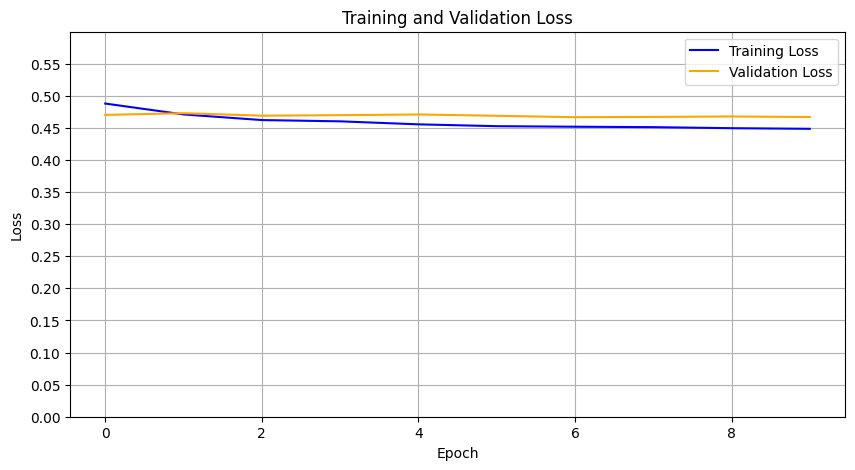

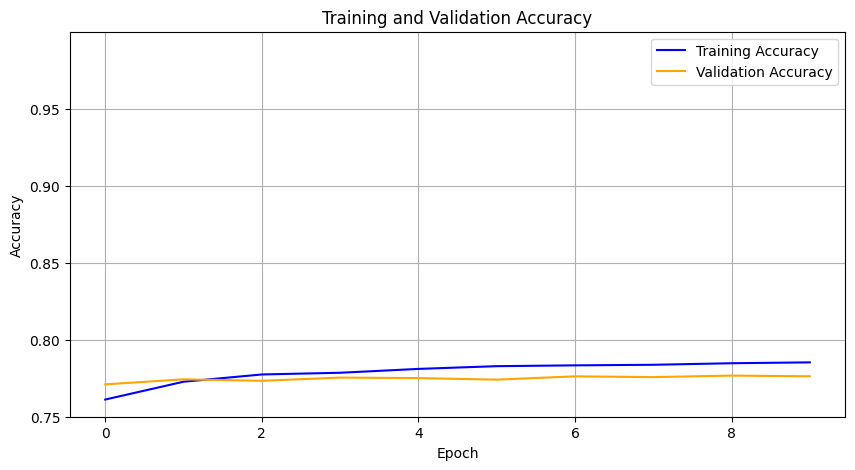

In [11]:
import matplotlib.pyplot as plt

# Obtén el historial de entrenamiento
history = history_GRU.history

# Grafica la pérdida
plt.figure(figsize=(10, 5))
plt.plot(history['loss'], label='Training Loss', color='blue')
plt.plot(history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
min_y=0
max_y=0.6
plt.ylim(min_y, max_y)
plt.yticks(np.arange(min_y, max_y, 0.05))
plt.show()

# Grafica el accuracy
plt.figure(figsize=(10, 5))
plt.plot(history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
min_y=0.75
max_y=1
plt.ylim(min_y, max_y)
plt.yticks(np.arange(min_y, max_y, 0.05))
plt.show()


In [12]:
from keras.layers import SimpleRNN
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, GlobalAveragePooling1D, Dense
from keras.callbacks import ReduceLROnPlateau
import numpy as np
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping


def create_model_SimpleRNN(input_dim):
    model = Sequential()
    model.add(SimpleRNN(100, return_sequences=True, input_shape=(None, input_dim)))
    model.add(SimpleRNN(100, return_sequences=True, input_shape=(None, input_dim)))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model


# Ajusta las dimensiones de las características de entrada
num_features = X_train.shape[1]
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, num_features))
X_valid_reshaped = X_valid.reshape((X_valid.shape[0], 1, num_features))

# Define un callback para reducir el LR basado en la pérdida de validación
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Crea y compila el modelo SimpleRNN
model_SimpleRNN = create_model_SimpleRNN(num_features)
initial_lr = 0.01
optimizer = Adam(learning_rate=initial_lr)

model_SimpleRNN.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Entrena el modelo con el callback para ajustar LR
history_RNN = model_SimpleRNN.fit(X_train_reshaped, y_train, epochs=EPOCAS, batch_size=1048, validation_data=(X_valid_reshaped, y_valid), callbacks=[reduce_lr, early_stop])

# Evalúa el modelo en el conjunto de prueba
loss, accuracy = model_SimpleRNN.evaluate(X_valid_reshaped, y_valid)
print("Loss:", loss)
print("Accuracy:", accuracy)


Epoch 1/10
11081/11081 [==============================] - 90s 8ms/step - loss: 0.4910 - accuracy: 0.7589 - val_loss: 0.4719 - val_accuracy: 0.7720 - lr: 0.0100
Epoch 2/10
11081/11081 [==============================] - 83s 8ms/step - loss: 0.4709 - accuracy: 0.7734 - val_loss: 0.4791 - val_accuracy: 0.7698 - lr: 0.0100
Epoch 3/10
11081/11081 [==============================] - 84s 8ms/step - loss: 0.4673 - accuracy: 0.7758 - val_loss: 0.4747 - val_accuracy: 0.7721 - lr: 0.0100
Epoch 4/10
11081/11081 [==============================] - 86s 8ms/step - loss: 0.4651 - accuracy: 0.7773 - val_loss: 0.4693 - val_accuracy: 0.7748 - lr: 0.0100
Epoch 5/10
11081/11081 [==============================] - 86s 8ms/step - loss: 0.4635 - accuracy: 0.7785 - val_loss: 0.4674 - val_accuracy: 0.7757 - lr: 0.0100
Epoch 6/10
11081/11081 [==============================] - 87s 8ms/step - loss: 0.4619 - accuracy: 0.7794 - val_loss: 0.4773 - val_accuracy: 0.7690 - lr: 0.0100
Epoch 7/10
11081/11081 [================

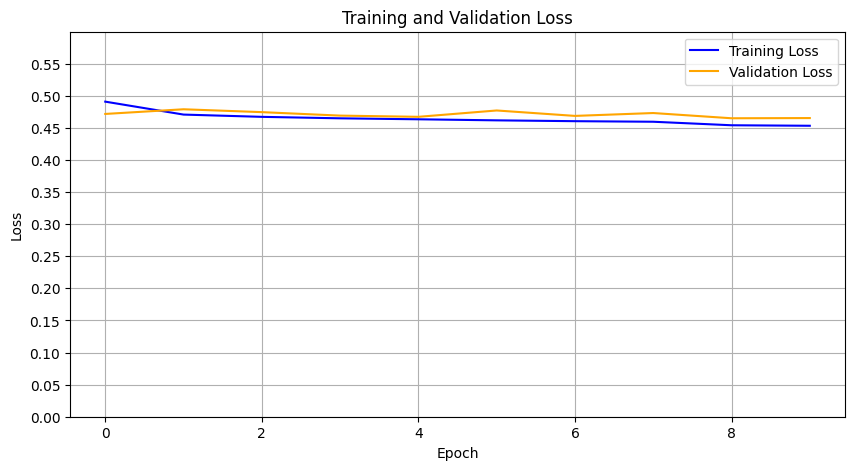

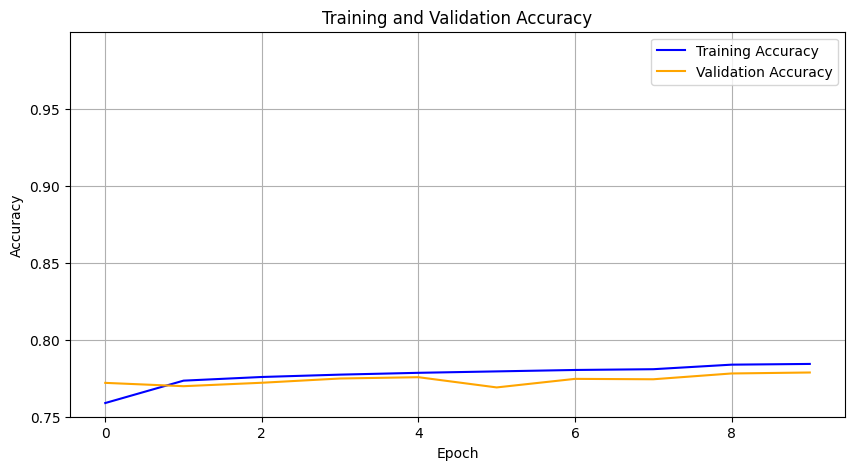

In [13]:
import matplotlib.pyplot as plt
# Obtén el historial de entrenamiento
history = history_RNN.history

# Grafica la pérdida
plt.figure(figsize=(10, 5))
plt.plot(history['loss'], label='Training Loss', color='blue')
plt.plot(history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
min_y=0
max_y=0.6
plt.ylim(min_y, max_y)
plt.yticks(np.arange(min_y, max_y, 0.05))
plt.show()

# Grafica el accuracy
plt.figure(figsize=(10, 5))
plt.plot(history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
min_y=0.75
max_y=1
plt.ylim(min_y, max_y)
plt.yticks(np.arange(min_y, max_y, 0.05))
plt.show()


In [17]:
# Ajusta las dimensiones de las características de entrada
num_features = X_train.shape[1]
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, num_features))
X_valid_reshaped = X_valid.reshape((X_valid.shape[0], 1, num_features))


In [19]:
print(num_features)
X_train_reshaped

5


array([[[0.        , 0.30261248, 0.54253263, 0.28080121, 0.03050949]],

       [[0.        , 0.30322897, 0.54240401, 0.2811278 , 0.00625377]],

       [[0.        , 0.30282883, 0.54228707, 0.28154522, 0.07464581]],

       ...,

       [[1.        , 0.19635355, 0.55769983, 0.40471044, 0.02923995]],

       [[1.        , 0.19624065, 0.55772446, 0.40472204, 0.00715109]],

       [[1.        , 0.19616451, 0.55785606, 0.40516844, 0.0014656 ]]])